In [46]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense ,Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_pacf

from vnstock import stock_historical_data
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing


In [47]:
data = stock_historical_data("GMD", "2020-01-01", "2024-08-19", "1D", 'stock', decor=True)
df = data.copy()
df.head()

,Open,High,Low,Close,Volume,Ticker
Time,,,,,,
2020-01-02,20020,20110,19890,19930,102780,GMD
2020-01-03,19930,20020,19510,19540,391080,GMD
2020-01-06,19510,19590,19080,19130,193970,GMD
2020-01-07,19130,19200,18650,18690,348050,GMD
2020-01-08,18650,18650,18040,18040,320710,GMD


In [48]:
def check(df):
    l = []
    columns = df.columns
    for col in columns:
        dtypes = df[col].dtypes
        nunique = df[col].nunique()
        sum_null = df[col].isnull().sum()
        l.append([col, dtypes, nunique, sum_null])
    df_check = pd.DataFrame(l)
    df_check.columns = ['Column','Dtypes','Nunique','Sum_null']
    return df_check 
check(df)

,Column,Dtypes,Nunique,Sum_null
0,Open,int32,626,0
1,High,int32,638,0
2,Low,int32,645,0
3,Close,int32,638,0
4,Volume,int32,1147,0
5,Ticker,object,1,0


In [49]:
df.describe().T.apply(lambda x: x.apply("{0:.3f}".format))

,count,mean,std,min,25%,50%,75%,max
Open,1156.000,44539.960,18723.825,12760.000,29820.000,45840.000,52410.000,84720.000
High,1156.000,45239.354,18918.103,13060.000,30487.500,46655.000,53345.000,85500.000
Low,1156.000,43840.974,18462.208,12110.000,29280.000,45140.000,51220.000,82870.000
Close,1156.000,44534.487,18681.387,12840.000,29895.000,45790.000,52275.000,84620.000
Volume,1156.000,1684162.725,1535122.839,33500.000,567845.000,1170300.000,2375350.000,10777940.000


Text(0.5, 1.0, 'Stock Price of Google over the Years')

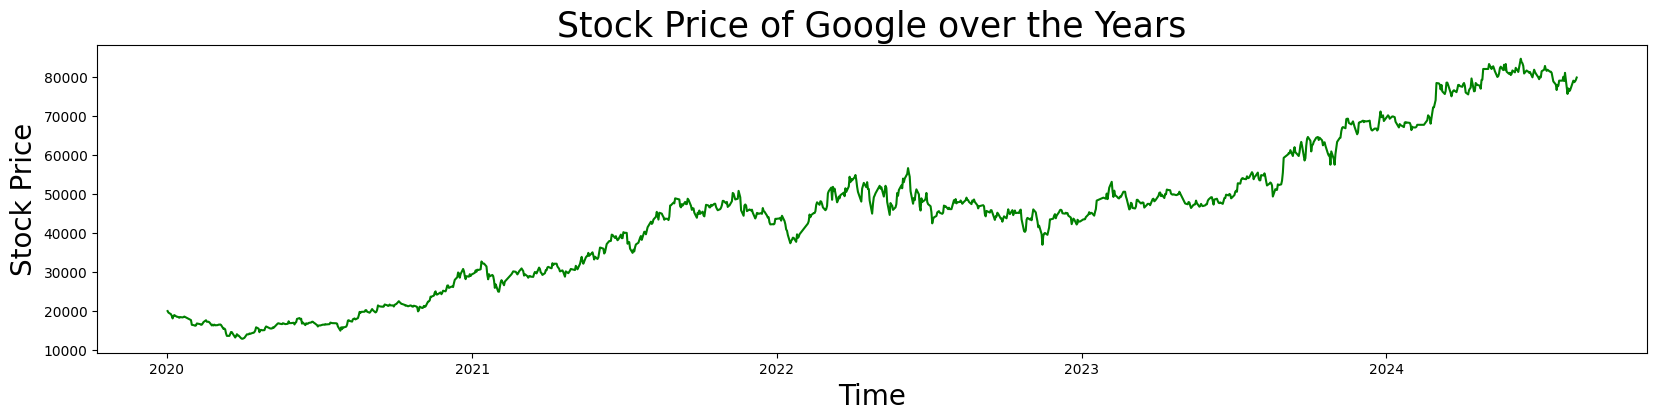

In [50]:
plt.figure(figsize=(20,4))
plt.plot(df['Close'], label='Close Price history',color='g')
plt.xlabel('Time',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Google over the Years',size=25)

### Exploratory Data Analysis

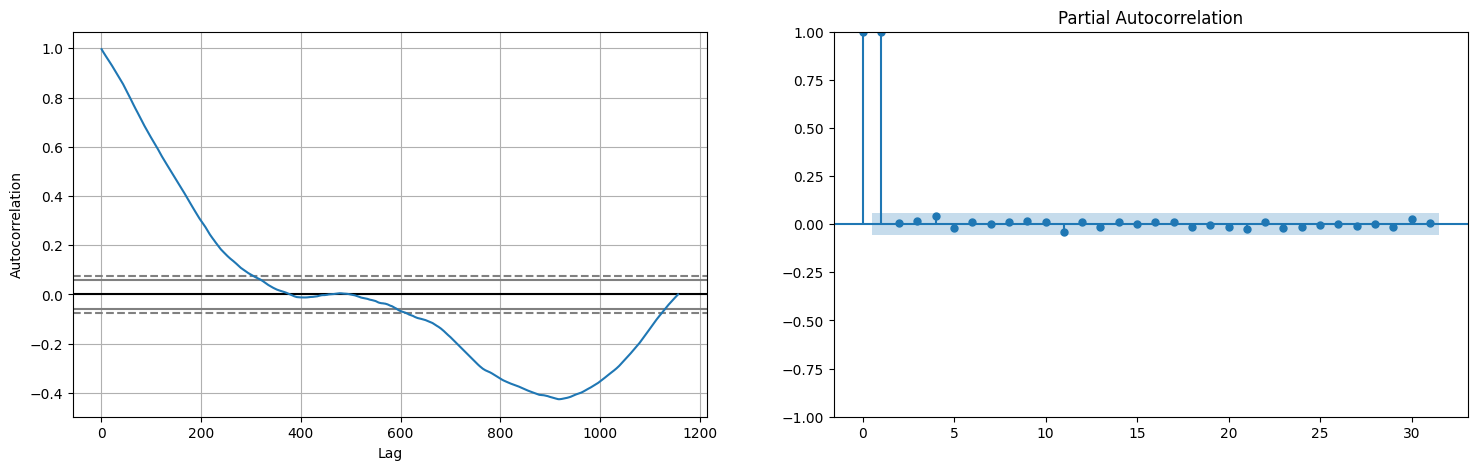

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
autocorrelation_plot(df['Close'], ax=axs[0])
plot_pacf(df['Close'], ax=axs[1])
plt.show()

In [7]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print('ADF:', dftest[0])
    print('P-value:', dftest[1])
    print('No. of lags:', dftest[2])
    print('Observation:', dftest[3])
    print('Critical values:')
    for key, val in dftest[4].items():
        print('\t', key, ':', val)
ad_test(df['Close'])

ADF: -0.23824860432711972
P-value: 0.9338062532483146
No. of lags: 3
Observation: 1152
Critical values:
	 1% : -3.436039176245612
	 5% : -2.8640521575678655
	 10% : -2.5681075333056036


In [53]:
data = df['Close']
length = int(len(df['Close']) * 0.90)
print('Length:', length)
print('Data length:',len(data))
train = data.iloc[:length]
print('Training shape',train.shape)
test = data.iloc[length:]
print('Testing shape',test.shape)

Length: 1040
Data length: 1156
Training shape (1040,)
Testing shape (116,)


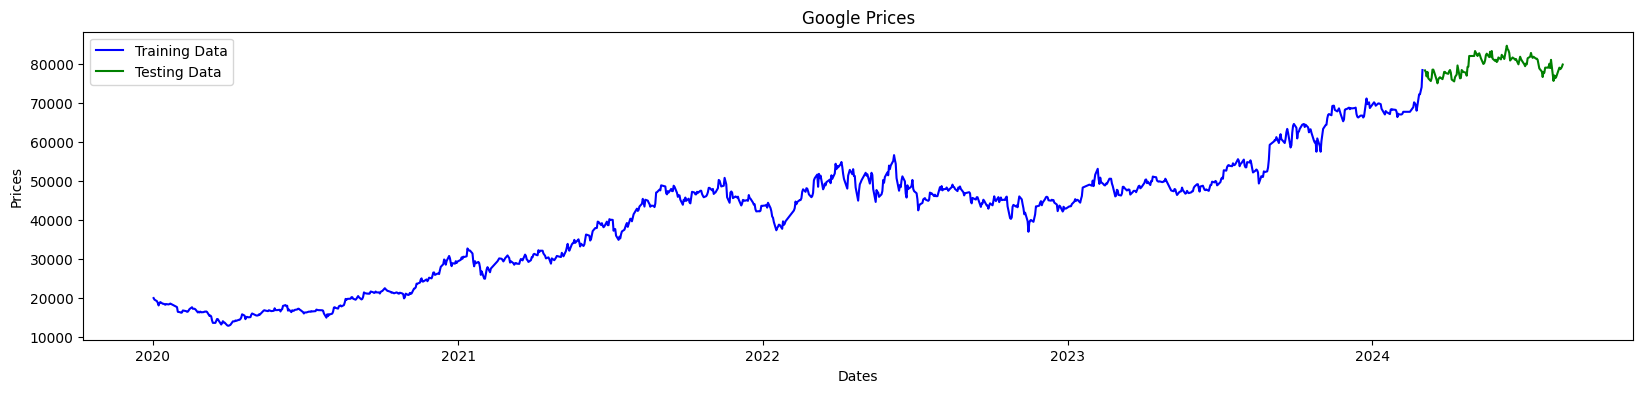

In [54]:
plt.figure(figsize=(20,4))
plt.title('Google Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train, 'blue', label='Training Data')
plt.plot(test, 'green', label='Testing Data')
plt.legend()

### SARIMAX

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17286.663, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17288.323, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17288.271, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17288.012, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17289.792, Time=0.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.526 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1040
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8641.332
Date:                Mon, 19 Aug 2024   AIC                          17286.663
Time:                        13:25:54   BIC                          17296.555
Sample:                             0   HQIC                         17290.416
                               - 1040                                  

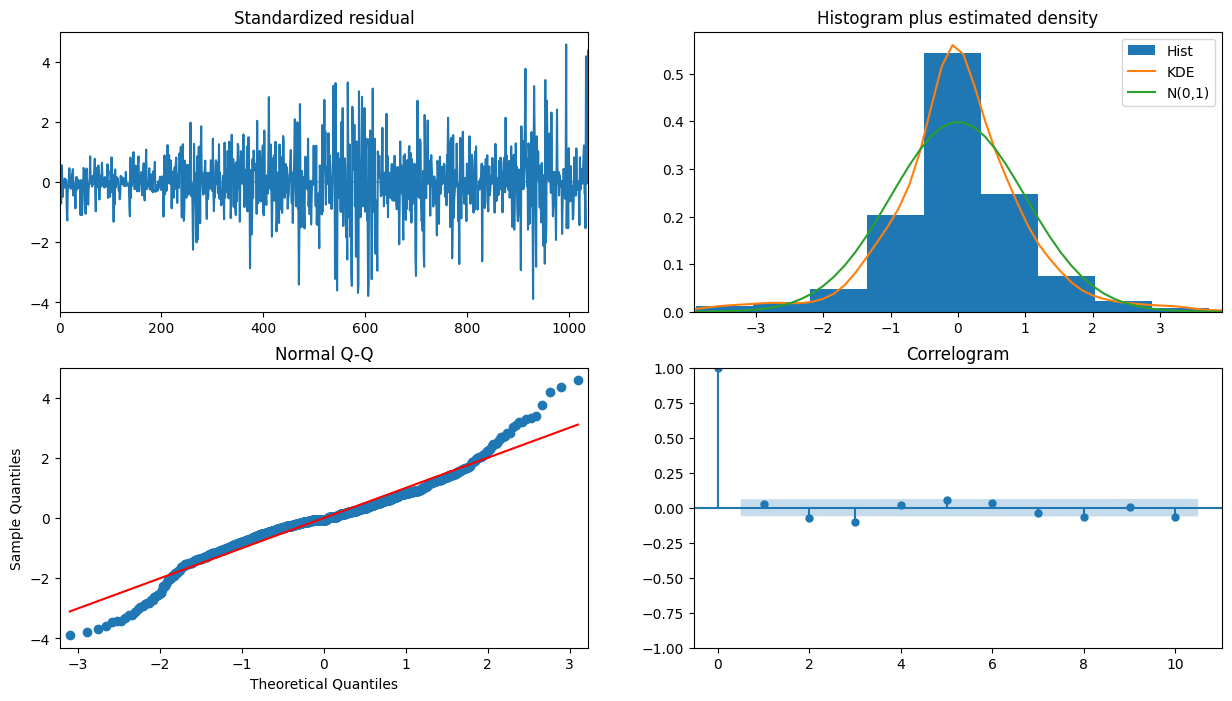

In [55]:
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [56]:
import statsmodels.api as sm

pred_start = test.index[0]
pred_end = test.index[-1]
model = sm.tsa.statespace.SARIMAX(data,order=(1,1,1))
model_fit = model.fit()
pred = model_fit.predict(start= pred_start , end = pred_end)
pred

Time
2024-03-04    78018.045403
2024-03-05    77964.249066
2024-03-06    77628.261356
2024-03-07    76550.709522
2024-03-08    77679.977083
                  ...     
2024-08-12    77157.453092
2024-08-13    78965.891577
2024-08-14    78587.636987
2024-08-15    78780.064146
2024-08-16    79164.381127
Name: predicted_mean, Length: 116, dtype: float64

In [57]:
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(test, pred)
mse_ratio = mse / 78018.05
mae = mean_absolute_error(test, pred)
r2 = r2_score(test, pred)
mse, mse_ratio, mae, r2

(1354038.8711241274, 17.355456476086335, 854.084513751858, 0.7431277220957934)

<Axes: xlabel='Time'>

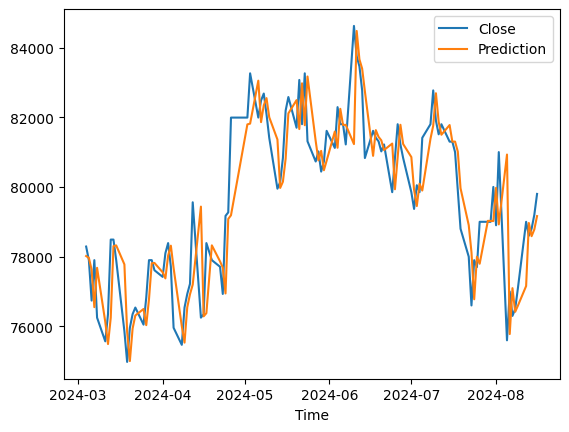

In [58]:
df_sarimax = pd.DataFrame(test)
df_sarimax["Prediction"] = pd.Series(pred, index=test.index)
df_sarimax.plot()

### LSTM

In [14]:
data1 = stock_historical_data("GMD", "2020-01-01", "2024-08-19", "1D", 'stock', decor=True)
data1

,Open,High,Low,Close,Volume,Ticker
Time,,,,,,
2020-01-02,20020,20110,19890,19930,102780,GMD
2020-01-03,19930,20020,19510,19540,391080,GMD
2020-01-06,19510,19590,19080,19130,193970,GMD
2020-01-07,19130,19200,18650,18690,348050,GMD
2020-01-08,18650,18650,18040,18040,320710,GMD
...,...,...,...,...,...,...
2024-08-12,77900,79800,77500,79000,563300,GMD
2024-08-13,79300,79400,78300,78600,220700,GMD
2024-08-14,79000,79000,77700,78800,707700,GMD


In [15]:
data_copy = data1.copy()

In [16]:
import math
data = data_copy.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*.8)  
training_data_len

925

In [60]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.09877403],
       [0.09334076],
       [0.08762887],
       ...,
       [0.91891892],
       [0.9244915 ],
       [0.93285038]])

In [59]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.09877403, 0.09334076, 0.08762887, 0.08149902, 0.07244358,
       0.08094177, 0.08442463, 0.0784341 , 0.0784341 , 0.07676233,
       0.07495124, 0.07731959, 0.07606576, 0.07731959, 0.07913068,
       0.06659237, 0.0497353 , 0.04792421, 0.04625244, 0.04735302,
       0.054472  , 0.05391474, 0.05210365, 0.0497353 , 0.05029256,
       0.054472  , 0.05934801, 0.06603511, 0.06060184, 0.06060184,
       0.06060184, 0.05865143, 0.04735302, 0.05029256, 0.04735302,
       0.05029256, 0.04792421, 0.04860685, 0.05029256, 0.05029256,
       0.05098913, 0.04917804, 0.03482864, 0.03650042, 0.03301755,
       0.01866815, 0.01016996, 0.01016996, 0.01741432, 0.02396211,
       0.02340485, 0.01811089, 0.00431875, 0.00919476, 0.01616049,
       0.01142379, 0.01142379, 0.00181109, 0.        , 0.        ])]
[0.003064920590693798]

[array([0.09877403, 0.09334076, 0.08762887, 0.08149902, 0.07244358,
       0.08094177, 0.08442463, 0.0784341 , 0.0784341 , 0.07676233,
       0.07495124, 0.07731959, 0.0

In [61]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0466
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0031
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0022
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0015
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0030
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0013
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0013
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0013
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - lo

In [25]:
from sklearn.metrics import mean_absolute_error


test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("RMSE: {:.4f}".format(rmse))    
print("MAE: {:.4f}".format(mae))
print("MSE: {:.4f}".format(mse))
print("R2 Score: {:.4f}".format(r2))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
RMSE: 1632.3233
MAE: 1292.0612
MSE: 2664479.3402
R2 Score: 0.9496


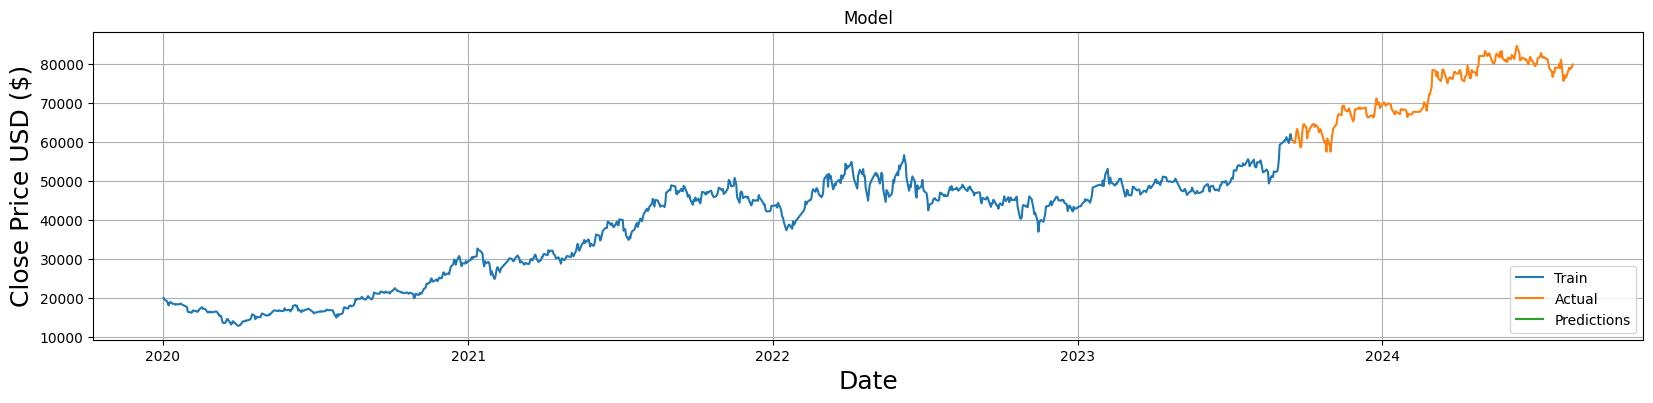

In [39]:
train = data[:training_data_len]
val = data[training_data_len:]
val['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(20,4))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(val[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.grid(True)
plt.show()

In [32]:
last_60_days = scaled_data[-60:]

x_input = np.array(last_60_days)
x_input = np.reshape(x_input, (1, x_input.shape[0], 1)) 
x_input

array([[[0.94580663],
        [0.94984675],
        [0.94176651],
        [0.94580663],
        [0.95806631],
        [0.9512399 ],
        [0.9675397 ],
        [0.96071329],
        [0.96071329],
        [0.95263305],
        [1.        ],
        [0.98787963],
        [0.98383951],
        [0.9742268 ],
        [0.94719978],
        [0.95806631],
        [0.95528002],
        [0.95388688],
        [0.94984675],
        [0.95263305],
        [0.93354695],
        [0.94719978],
        [0.96071329],
        [0.95263305],
        [0.94719978],
        [0.93354695],
        [0.92685985],
        [0.93633324],
        [0.93354695],
        [0.95528002],
        [0.96071329],
        [0.9742268 ],
        [0.96210644],
        [0.95667317],
        [0.96071329],
        [0.95374756],
        [0.95374756],
        [0.94956812],
        [0.93424352],
        [0.91891892],
        [0.90777375],
        [0.88826971],
        [0.90638061],
        [0.90359432],
        [0.92170521],
        [0

In [29]:
future_steps = 30  
predictions = []

for _ in range(future_steps):
    pred = model.predict(x_input)
    predictions.append(pred[0, 0])
    
    pred_reshaped = np.reshape(pred, (1, 1, 1)) 
    x_input = np.append(x_input[:, 1:, :], pred_reshaped, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [30]:
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [36]:
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=future_steps)
predictions = pd.DataFrame(data=predictions, index=future_dates, columns=['Predicted'])
predictions

,Predicted
2024-08-17,78421.695312
2024-08-18,77884.796875
2024-08-19,77168.585938
2024-08-20,76433.242188
2024-08-21,75737.898438
2024-08-22,75108.070312
2024-08-23,74552.546875
2024-08-24,74069.679688
2024-08-25,73651.703125
2024-08-26,73287.625000


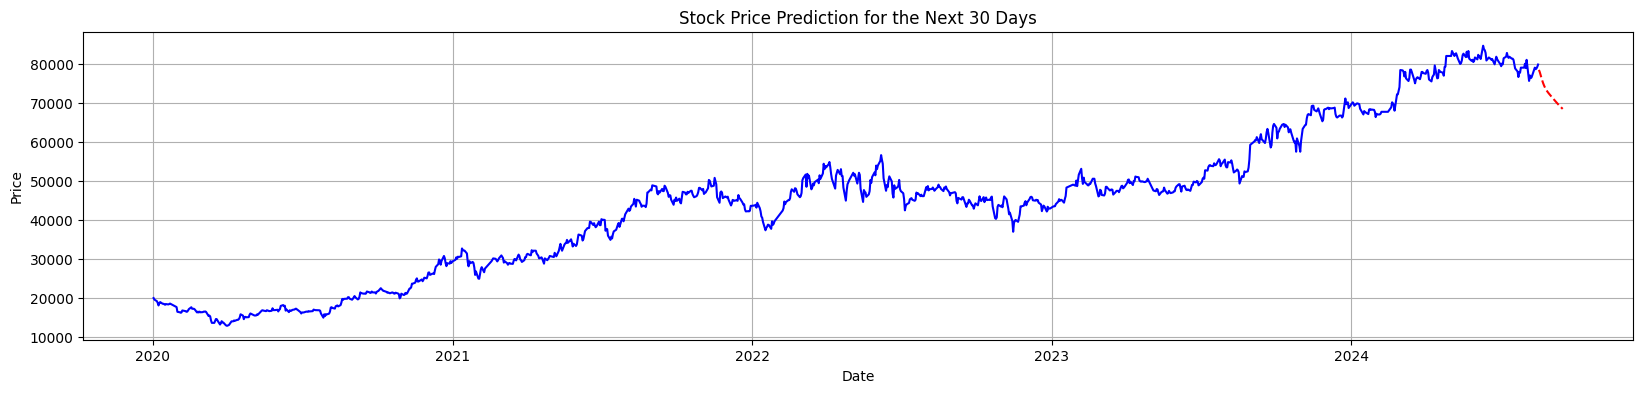

In [38]:
plt.figure(figsize=(20, 4))
plt.plot(data.index, data['Close'], label='Actual Price', color='blue')
plt.plot(predictions.index, predictions['Predicted'], label='Predicted Price', color='red', linestyle='--')
plt.title('Stock Price Prediction for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()